In [1]:
from rotorcraft import ConventionalRotorcraft, CoaxialRotorcraft, TiltRotorcraft
from mission_design import FlightMissionScenario, DesignConstraints, DesignAssumptions
import matplotlib.pyplot as plt
import numpy as np
import csv

## Mission setup

In [2]:
# don't really need hover apart from identification of sampling/landing locations
# 3 minutes used in consideration of this and additional redundancy around takeoff/landing
mission_scenario = FlightMissionScenario(
        hover_time=3*60, forward_flight_distance=600, climb_height=50, 
        climb_rate=10, descent_rate=10)
MASS_LIMIT = 50
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()

## Create aircraft

In [3]:
design_constraints.MAX_DIAMETER = 1000

coaxial = CoaxialRotorcraft("Coaxial - Ingenuity-like", 2, 4, mission_scenario, design_constraints, design_assumptions)
quad = ConventionalRotorcraft("Quadcopter", 4, 4, mission_scenario, design_constraints, design_assumptions)
hex = ConventionalRotorcraft("Hexcopter", 6, 4, mission_scenario, design_constraints, design_assumptions)
octo = ConventionalRotorcraft("Octocopter", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
tiltrotor = TiltRotorcraft("Hex-tiltrotor", 6, 4, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [coaxial, quad, hex, octo, quad_coaxial, tiltrotor]

### If want to write to csv

In [4]:
def write_to_csv():
    design_masses = [20, 25, 30, 35, 40, 45, 50]
    with open("data.csv", "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        header_str = "aircraft,no_rotors,no_nontilting_rotors,no_blades,max_thrust_requirement,rotor_radius,max_thrust_power,hover_power,f_flight_power,motor_rpm_hover,motor_power,motor_power_spec,motor_torque,max_forward_velocity,total_energy,flight_energy,ground_energy,sampling_energy,sleep_energy,design_mass,contingency_mass,motor_mass,battery_mass,solar_panel_mass,rotor_mass,structure_mass,ground_mobility_mass,flight_elec_mass,total_empty_mass,payload"
        header = header_str.split(',')
        csv_writer.writerow(header)
        for aircraft in aircrafts:
            for design_mass in design_masses:
                aircraft.calc_and_verify_initial_design(design_mass)
                csv_writer.writerow(aircraft.get_csv_summary())

# write_to_csv()

## Perform analyses

### Initial verification

In [ ]:
design_mass = 20
for aircraft in aircrafts:
    payload = aircraft.calc_and_verify_initial_design(design_mass)

### Payload efficiency tradeoff

Vary design_mass and calculate payload/design_mass

In [ ]:
plt.figure()
for aircraft in aircrafts:
    design_masses, payload_efficiences = aircraft.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=aircraft.name)
plt.title(f"Payload efficiency vs design mass")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend()
plt.show()

### Payload vs hover/range benefits tradeoff

- fix design_mass (maybe at MASS_LIMIT, maybe at maximum payload efficiency) 
- decrease the proportion of payload for sampling and move into battery to provide more energy/power
- back calculate HOVER_TIME or FORWARD_FLIGHT_RANGE from total_power

Assumption:
- for the purpose of this ignoring the climb/descent power

Purpose:
- helpful to explore how incorrect assumption of lander accuracy could be overcome

In [ ]:
for aircraft in aircrafts:
    MIN_PAYLOAD = 2
    valid_payloads, hover_times, ranges = aircraft.trade_payload_for_battery(design_mass, MIN_PAYLOAD)

    mass_max_payload_efficiency = design_masses[np.argmax(payload_efficiences)]
    valid_payloads, hover_times, ranges = aircraft.trade_payload_for_battery(mass_max_payload_efficiency, MIN_PAYLOAD)

    plt.figure()
    for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
        plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}")
    plt.xlabel('Hover Time')
    plt.ylabel('Range')
    plt.title(f'Hover Time vs Range for Different Payloads: {aircraft.name}')
    plt.legend()
    plt.grid(True) 
plt.show()

    

## Effects of inaccuracies in mass estimations

### Fixed electronics mass tradeoff

In [ ]:
plt.figure()
electronics_masses = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for electronics_mass in electronics_masses:
    design_assumptions.ELECTRONICS_MASS = electronics_mass
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    design_masses, payload_efficiences = quad_coaxial.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=f"{electronics_mass:.1f}kg")
plt.title(f"Payload efficiency vs design mass for varying electronics mass")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend()
plt.show()

### Contingency factor effect on payload efficiency

In [ ]:
plt.figure()
contingencies = [0, 0.1, 0.2, 0.3, 0.4]
for contingency in contingencies:
    design_constraints.CONTINGENCY_WEIGHT_FACTOR = contingency
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    design_masses, payload_efficiences = quad_coaxial.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=f"{contingency*100}%")
plt.title(f"Payload efficiency vs design mass for varying contingency factor")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:


fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(12,6))
contingencies = [0, 0.1, 0.2, 0.3, 0.4]
design_masses = [10, 15, 20, 25, 30, 35, 40, 45, 50]
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()
for contingency in contingencies:
    design_constraints.CONTINGENCY_WEIGHT_FACTOR = contingency
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    ax1.plot(design_masses, payloads, label=f"{contingency*100}%")
ax1.set_xlabel("Mass contingency")
ax1.set_ylabel("Payload (kg)")
ax1.grid(True)
ax1.legend()

design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()
gm_props = [0.01, 0.02, 0.05, 0.08, 0.1, 0.15]
for gm_prop in gm_props:
    design_assumptions.GROUND_MOBILITY_MASS_PROPORTION = gm_prop
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    ax2.plot(design_masses, payloads, label=f"{gm_prop*100}%")
ax2.set_title("Ground mobility mass factor")
ax2.set_xlabel("Design mass (kg)")
ax2.set_ylabel("Payload (kg)")
ax2.grid(True)
ax2.legend()

design_assumptions = DesignAssumptions()
rotor_mass_factors = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
for rotor_mass_factor in rotor_mass_factors:
    design_assumptions.ROTOR_MASS_FACTOR = rotor_mass_factor
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    ax3.plot(design_masses, payloads, label=f"{rotor_mass_factor}")
ax3.set_title("Rotor mass factor")
ax3.set_xlabel("Design mass (kg)")
ax3.set_ylabel("Payload (kg)")
ax3.grid(True)
ax3.legend()

design_assumptions = DesignAssumptions()
motor_mass_factors = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
for motor_mass_factor in motor_mass_factors:
    design_assumptions.MOTOR_MASS_FACTOR = motor_mass_factor
    print(design_assumptions.MOTOR_MASS_FACTOR)
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    ax4.plot(design_masses, payloads, label=f"{motor_mass_factor}")
ax4.set_title("Motor mass factor")
ax4.set_xlabel("Design mass (kg)")
ax4.set_ylabel("Payload (kg)")
ax4.grid(True)
ax4.legend()
plt.suptitle("Varying mass considerations effect on payload (for different design masses)")
plt.tight_layout()
plt.show()


In [ ]:


fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(12,6))
contingencies = [0, 0.1, 0.2, 0.3, 0.4]
design_masses = [10, 15, 20, 25, 30, 35, 40, 45, 50]
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()
payloads_data = {mass: [] for mass in design_masses}
for contingency in contingencies:
    design_constraints.CONTINGENCY_WEIGHT_FACTOR = contingency
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[design_masses[i]].append(payload)
for mass, payloads in payloads_data.items():
    ax1.plot(contingencies, payloads, label=f"{mass}kg")
ax1.set_xlabel("Mass contingency")
ax1.set_ylabel("Payload (kg)")
ax1.grid(True)
ax1.legend()

design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()
gm_props = [0.01, 0.02, 0.05, 0.08, 0.1, 0.15]
payloads_data = {mass: [] for mass in design_masses}
for gm_prop in gm_props:
    design_assumptions.GROUND_MOBILITY_MASS_PROPORTION = gm_prop
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[design_masses[i]].append(payload)
for mass, payloads in payloads_data.items():
    ax2.plot(gm_props, payloads, label=f"{mass}kg")
ax2.set_xlabel("Ground mobility mass factor")
ax2.set_ylabel("Payload (kg)")
ax2.grid(True)
ax2.legend()

design_assumptions = DesignAssumptions()
rotor_mass_factors = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
payloads_data = {mass: [] for mass in design_masses}
for rotor_mass_factor in rotor_mass_factors:
    design_assumptions.ROTOR_MASS_FACTOR = rotor_mass_factor
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[design_masses[i]].append(payload)
for mass, payloads in payloads_data.items():
    ax3.plot(rotor_mass_factors, payloads, label=f"{mass}kg")
ax3.set_xlabel("Rotor mass factor")
ax3.set_ylabel("Payload (kg)")
ax3.grid(True)
ax3.legend()

design_assumptions = DesignAssumptions()
motor_mass_factors = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
payloads_data = {mass: [] for mass in design_masses}
for motor_mass_factor in motor_mass_factors:
    design_assumptions.MOTOR_MASS_FACTOR = motor_mass_factor
    print(design_assumptions.MOTOR_MASS_FACTOR)
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions)
    payloads = []
    for design_mass in design_masses:
        try:
            payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[design_masses[i]].append(payload)
for mass, payloads in payloads_data.items():
    ax4.plot(motor_mass_factors, payloads, label=f"{mass}kg")
ax4.set_xlabel("Motor mass factor")
ax4.set_ylabel("Payload (kg)")
ax4.grid(True)
ax4.legend()
plt.suptitle("Varying mass considerations effect on payload (for different design masses)")
plt.tight_layout()
plt.show()


## Number of blade effects


Quad coaxial
-----
New analysis: calculation and verification of initial design
-----

Design mass of rotorcraft is: 10.00kg
Maximum thrust required is: 55.65N
Rotor radius required to produce maximum thrust is 0.57m
Max thrust power calculations:
Induced power per rotor is 63.26W, profile power per rotor is 33.46W
Power required for maximum thrust is: 1137.84W
Motor rotational speed at hover: 3148.18RPM
Power required from the motors at max thrust is: 1137.84W
Hover power calculations:
Induced power per rotor is 63.26W, profile power per rotor is 18.21W
Motor is specced to: 1437.74W (150% hover power)
Maximum torque required at maximum thrust is: 3.45N.m
Maximum forward velocity of aircraft is: 66.52m/s
----
Energy calculations
----
Forward velocity used for mission: 30.00m/s
Hover power calculations:
Induced power per rotor is 63.26W, profile power per rotor is 18.21W
Forward flight power calculations
Induced power per rotor is 96.93W, profile power per rotor is 56.02W
Single flight

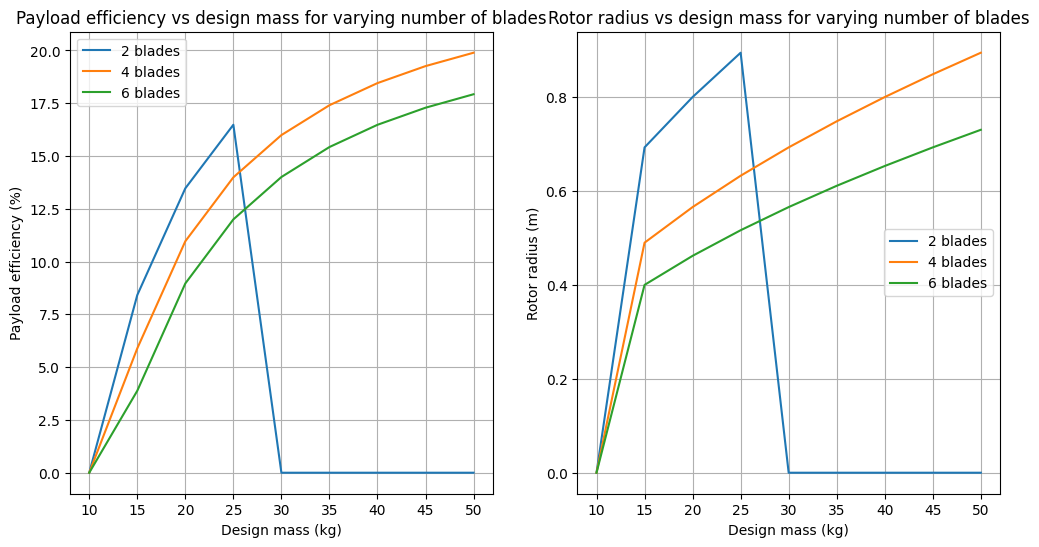

In [5]:
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
blades = [2, 4, 6]
for no_blades in blades:
    quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, no_blades, mission_scenario, design_constraints, design_assumptions)
    design_masses, payload_efficiences, rotor_radiuses = quad_coaxial.number_of_blades_analysis()
    ax1.plot(design_masses, np.array(payload_efficiences)*100, label=f"{no_blades} blades")
    ax2.plot(design_masses, np.array(rotor_radiuses), label=f"{no_blades} blades")
ax1.set_title(f"Payload efficiency vs design mass for varying number of blades")
ax1.set_xlabel("Design mass (kg)")
ax1.set_ylabel("Payload efficiency (%)")
ax1.grid(True)
ax1.legend()
ax2.set_title(f"Rotor radius vs design mass for varying number of blades")
ax2.set_xlabel("Design mass (kg)")
ax2.set_ylabel("Rotor radius (m)")
ax2.grid(True)
ax2.legend()
plt.show()